<h1>Poles/Zeros/Gain from Look-Up Tables (Prototyping)</h1>
KNK Feb 2021: Working off of BSM's original ipynb, factoring out numeric methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.gridspec import GridSpec
from plot_helpers import plot_response
from scipy import signal

from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LM
from tf_helpers import Fit_ZerosPolesGain_toFrequencyResponse_LLSQ
from plot_helpers import plot_response
from vectfit_python import vectfit
from zen import zen_response

%matplotlib inline

In [2]:
# NIMS FILTERS
#   These values are from here:
#   http://service.iris.edu/fdsnws/station/1/query?net=EM&sta=IDA11&cha=*&level=response&format=xml&nodata=404
#   ALSO can pull these from an sp file (gains are clearer in sp files)

# B fields, one filter:
zeros_Blowpass = []
poles_Blowpass = [-6.28319 + 10.8825j, -6.28319 - 10.8825j, -12.5664]
gain_Blowpass = 1984.31
NIMS_Magnetic_3PoleLowpass = \
    signal.ZerosPolesGain(zeros_Blowpass, poles_Blowpass, gain_Blowpass)

# E fields, two filters:
zeros_Ehighpass = [0.]
poles_Ehighpass = [-1.66667E-4]
gain_Ehighpass = 1.
NIMS_Electric_Highpass = \
    signal.ZerosPolesGain(zeros_Ehighpass, poles_Ehighpass, 
                          gain_Ehighpass)

zeros_Elowpass = []
poles_Elowpass = [-3.88301 + 11.9519j, -3.88301 - 11.9519j, 
                  -10.1662 + 7.38651j, -10.1662 - 7.38651j, 
                  -12.5664]
gain_Elowpass = 313384.
NIMS_Electric_5PoleLowpass = \
    signal.ZerosPolesGain(zeros_Elowpass, poles_Elowpass, gain_Elowpass)

zeros_e_total = zeros_Ehighpass + zeros_Elowpass
poles_e_total = poles_Ehighpass + poles_Elowpass
gain_e_total = gain_Ehighpass * gain_Elowpass
print(poles_e_total)
NIMS_Electric_Total = signal.ZerosPolesGain(zeros_e_total, poles_e_total, gain_e_total)

[-0.000166667, (-3.88301+11.9519j), (-3.88301-11.9519j), (-10.1662+7.38651j), (-10.1662-7.38651j), -12.5664]


In [3]:
# ZEN COIL RESPONSE
# angular frequency, real, imaginary

zen_angular_frequencies = zen_response[:, 0]
zen_period = 2. * np.pi / zen_angular_frequencies
zen_complex_response = zen_response[:, 1] + 1.j * zen_response[:, 2]
zen_amplitude_response = np.absolute(zen_complex_response)
zen_phase_response = np.angle(zen_complex_response, deg=True)

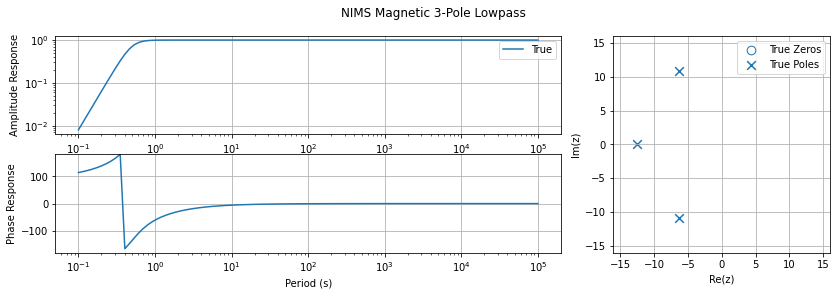

In [4]:
w = 2. * np.pi / np.logspace(5, -1, num=100)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, w_values=w, title='NIMS Magnetic 3-Pole Lowpass')

No handles with labels found to put in legend.


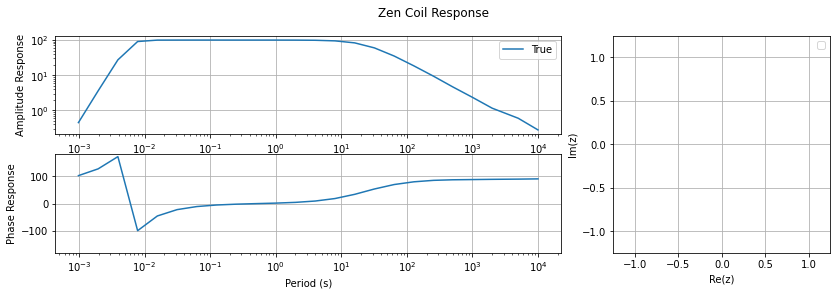

In [5]:
w = 2. * np.pi / np.logspace(-1, 5, num=100)
plot_response(w_obs=zen_angular_frequencies, resp_obs=zen_complex_response, title='Zen Coil Response')

<h2>Non-Linear Least Squares Fitting</h2>

Using nonlinear least squares with Levenberg-Marquardt step length damping to fit poles and zeros representation to look-up table of complex system response. Nominally, the target function is of the form

             
$ 
\displaystyle zpk(s) = k \frac{(s-z_{1})(s-z_{2})(s-z_{3})...(s-z_{m})}{(s-p_{1})(s-p_{2})(s-p_{3})...(s-p_{n})}
$

where s is complex frequency ($s = i\omega$, where $\omega$ is angular frequency), $k$ is the overall system gain, $z$ represents the $m$ system zeros, and $p$ represents the $n$ system poles.
   
HOWEVER. We're actually going to fit the look-up table with the transfer function form of the system response function:

        
$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} $

where $ a_{x} $ and $ b_{x} $ are the (real) coefficients on the numerator and denominator polynomials, $m$ is the number of system zeros (also the degree of the numerator polynomial), $n$ is the number of system poles (also the degree of the denominator polynomial), and $s$ is complex frequency ($s = i\omega$, where $\omega$ in angular frequency).

This form has several benefits. First of all, because the coefficients are real, the roots of these polynomials (and therefore the poles/zeros) will occur as complex conjugate pairs, which is what we expect/require for a real linear system operating on a real time series (I think...). Having real coefficients in this polynomial form also makes the math a bit easier.

Then, to find the poles/zeros, we just have to factor the numerator and denominator of this rational function. Operationally, we'll just use Python tools to do so.

For the nonlinear least squares fitting, the Jacobian is fairly simple to calculate:

$ \displaystyle \frac{\partial h(s)}{\partial a_{m}} = \frac{s^{m}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} = \frac{s^{m}}{d(s)} $

(Other partial derivatives with respect to the numerator terms are similar.)

$ \displaystyle \frac{\partial h(s)}{\partial b_{n}} = -\frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{(b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0})^{2}} s^{n} = -\frac{n(s)}{d(s)^{2}}s^{n} $

(Other partial derivatives with respect to the denominator terms are similar.)

Here, $n(s)$ and $d(s)$ are the numerator and denominator polynomials, respectively.

In the matrices here, all the numerator terms will be listed first, then all the denominator terms.

**Nonlinear LM fit to NIMS B response**

PARAMETERIZATION: 0 zeros, 3 poles
Initial Numerator Guess:  [1.+0.j]
Initial Denominator Guess:  [1.+0.j 1.+0.j 1.+0.j 1.+0.j]
Initial misfit:  0.3905301610061775
Misfit Step 1:  0.3403990610683085
Misfit Step 2:  0.364175109332949
Misfit Step 3:  0.3060996107464751
Misfit Step 4:  0.355562825616186
Misfit Step 5:  0.28887850705540613
Misfit Step 6:  0.2445792851234965
Misfit Step 7:  0.21663084876634714
Misfit Step 8:  0.1827350637992361
Misfit Step 9:  0.1545248385960636
Misfit Step 10:  0.15382987812226132


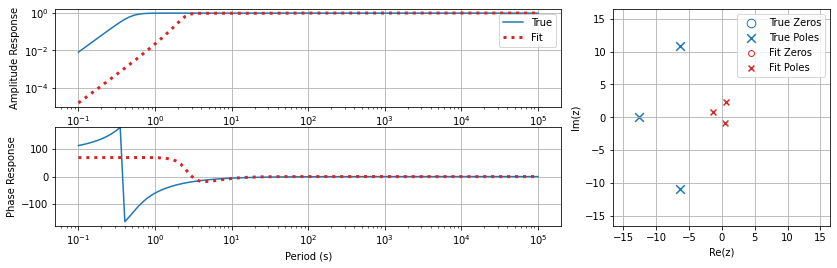

In [6]:
print("PARAMETERIZATION: 0 zeros, 3 poles")
test_period = np.logspace(-1, 5, num=100)
test_w = 2. * np.pi / test_period
NIMS_w, NIMS_Bresp = signal.freqresp(NIMS_Magnetic_3PoleLowpass, 
                                     w=test_w)   # w is in rad/sec
NIMS_LM_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LM(NIMS_w, 
                                                        NIMS_Bresp, 
                                                        0, 3)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_LM_ZPK, 
              w_values=test_w)

Ok, so the non-linear least squares approach isn't working so well. Apparently there's no guarantee that the model updates will be purely real (as I had hoped), and it's not converging very well. This could be because I used a bad initial guess, or because I'm doing something wrong. But let's try something else...

20210208: KNK says: maybe, but we could add some constriains to the objective function here 

<h2>Linear Least Squares</h2>

We can do some equation manipulation to turn this into a linear least squares problem. Again starting with the transfer function representation of the response function:

$ \displaystyle h(s) = \frac{a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0}}{b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}} = \frac{n(s)}{d(s)} $

where $ a_{x} $ and $ b_{x} $ are the (real) coefficients on the numerator and denominator polynomials, $m$ is the number of system zeros (also the degree of the numerator polynomial), $n$ is the number of system poles (also the degree of the denominator polynomial), and $s$ is complex frequency ($s = i\omega$, where $\omega$ in angular frequency).

Rearranging this equation...

$ d(s) \cdot h(s) = n(s) $

$ \displaystyle (b_{n}s^{n} + b_{n-1}s^{n-1} + ... + b_{1}s^{1} + b_{0}) \cdot h(s) = a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0} $

If we require $ b_{0} = 1 $, then we can get this into a convenient linear least squares form. (Note that $ b_{0} = 1 $ just means that all the other polynomial coefficients are effectively normalized by whatever $ b_{0} $ would've been before.)

$ \displaystyle b_{n}s^{n} \cdot h(s) + b_{n-1}s^{n-1} \cdot h(s) + ... + b_{1}s^{1} \cdot h(s) + 1 \cdot h(s) = a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0} $

$ \displaystyle h(s) = a_{m}s^m + a_{m-1}s^{m-1} + ... + a_{1}s^{1} + a_{0} - b_{n}s^{n} \cdot h(s) - b_{n-1}s^{n-1} \cdot h(s) - ... - b_{1}s^{1} \cdot h(s) $

So now we can have the complex response values $ h(s) $ in the RHS vector $ \mathbf d $; the coefficients $ a_{m} $ and $ b_{m} $ as the model parameter $ \mathbf m $; $ s^{m} $ and $ - s^{n} \cdot h(s) $ in the design matrix $ \mathbf G $.

$ \displaystyle \mathbf d = \mathbf G \mathbf m $

$ \begin{bmatrix} h(s_{0}) \\ h(s_{1}) \\ \vdots \\ h(s_{k}) \end{bmatrix} = 
\begin{bmatrix} 
s_{0}^{m} & s_{0}^{m-1} & \dots & s_{0}^{1} & 1 & -s_{0}^{n} \cdot h(s_{0}) & -s_{0}^{n-1} \cdot h(s_{0}) & \dots & -s_{0}^{1} \cdot h(s_{0}) \\ 
s_{1}^{m} & s_{1}^{m-1} & \dots & s_{1}^{1} & 1 & -s_{1}^{n} \cdot h(s_{1}) & -s_{1}^{n-1} \cdot h(s_{1}) & \dots & -s_{1}^{1} \cdot h(s_{1})\\ 
 & & & & & \vdots & & & \\ 
s_{k}^{m} & s_{k}^{m-1} & \dots & s_{k}^{1} & 1 & -s_{k}^{n} \cdot h(s_{k}) & -s_{k}^{n-1} \cdot h(s_{k}) & \dots & -s_{k}^{1} \cdot h(s_{k}) 
\end{bmatrix} 
\begin{bmatrix} a_{m} \\ a_{m-1} \\ \vdots \\ a_{1} \\ a_{0} \\ b_{n} \\ b_{n-1} \\ \vdots \\ b_{1} \end{bmatrix} $

This formulation of a linear least-squares problem is sometimes called the "error-equation" method or the Levy Method in the signal processing literature. However, this form is suboptimal, as the denominator coefficients $ b_{n} $ are effectively weighted by the response values $ h(s) $. A simple method to deal with this bias is to iteratively weight (divide) the linear least squares problem by the denominator term $ d(s_{k}) $ from the previous iteration until convergence. This is called Sanathanan-Koerner iteration.

<br><br> 
**Fitting NIMS B response with linear approach, no S-K iteration and no regularization**

PARAMETERIZATION: 0 zeros, 3 poles


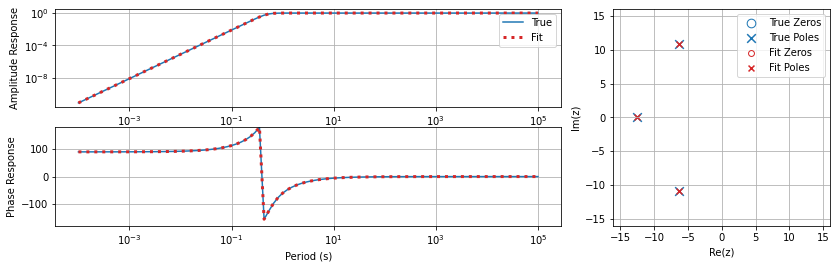

ZerosPolesGainContinuous(
array([], dtype=float64),
array([ -6.28319+1.08825000e+01j, -12.5664 -1.36314571e-13j,
        -6.28319-1.08825000e+01j]),
(1984.3100000000027+3.226633120824021e-12j),
dt: None
)


In [11]:
n_zeros = 0
n_poles = 3
print("PARAMETERIZATION: {} zeros, {} poles".format(n_zeros, n_poles))

test_period = np.logspace(-4, 5, num=100)
test_w = 2. * np.pi / test_period
NIMS_w, NIMS_Bresp = signal.freqresp(NIMS_Magnetic_3PoleLowpass, 
                                     w=test_w)
NIMS_Fit_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, 
                                                           NIMS_Bresp, 
                                                           n_zeros, n_poles)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_Fit_ZPK, 
              w_values=test_w)
print(NIMS_Fit_ZPK)

In [12]:
type(NIMS_Fit_ZPK)
n_poles = len(NIMS_Fit_ZPK.poles)
print(n_poles, "poles ", NIMS_Fit_ZPK.poles)
for i_pole in range(n_poles):
    print(i_pole, NIMS_Fit_ZPK.poles[i_pole])
n_zeros = len(NIMS_Fit_ZPK.zeros)
print(n_zeros, "zeros ", NIMS_Fit_ZPK.zeros)
for i_zero in range(n_zeros):
    print(i_zero, NIMS_Fit_ZPK.zeros[i_zero])

3 poles  [ -6.28319+1.08825000e+01j -12.5664 -1.36314571e-13j
  -6.28319-1.08825000e+01j]
0 (-6.283189999999969+10.882499999999979j)
1 (-12.56640000000005-1.363145707422575e-13j)
2 (-6.2831900000000855-10.882499999999938j)
0 zeros  []


PARAMETERIZATION: 7 zeros, 7 poles


/home/kkappler/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1628: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


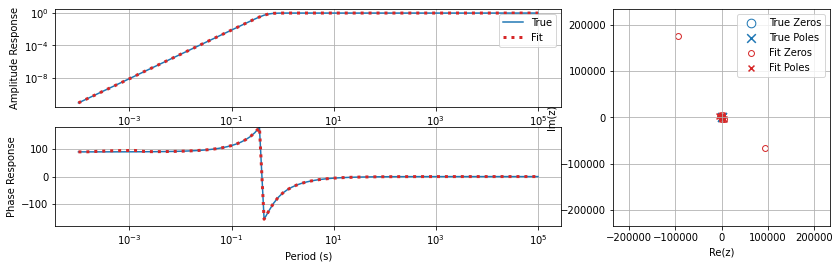

In [13]:
print("PARAMETERIZATION: 7 zeros, 7 poles")
NIMS_Fit_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, 
                                                           NIMS_Bresp, 
                                                           7, 7)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_Fit_ZPK, 
              w_values=test_w)

<br><br> 
**Fitting NIMS B response with linear approach, using S-K iteration**

PARAMETERIZATION: 0 zeros, 3 poles
Number of S-K iterations:  1


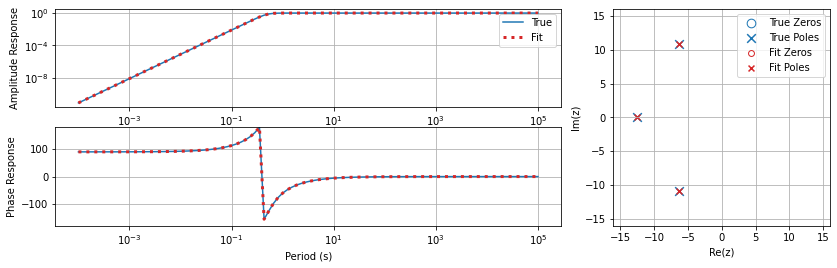

In [14]:
print("PARAMETERIZATION: 0 zeros, 3 poles")
NIMS_Fit_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, NIMS_Bresp, 
                                                0, 3, 
                                                useSKiter=True)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_Fit_ZPK, 
              w_values=test_w)

PARAMETERIZATION: 7 zeros, 7 poles
Number of S-K iterations:  1


/home/kkappler/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1628: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


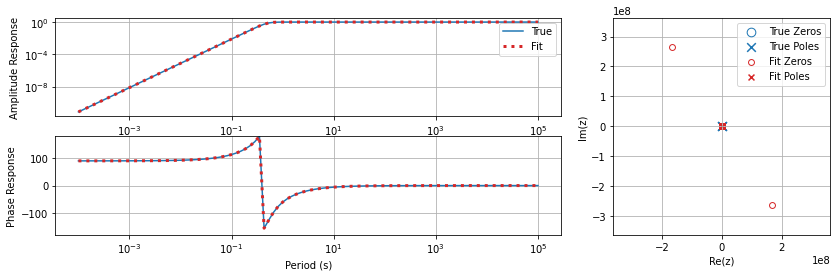

In [15]:
print("PARAMETERIZATION: 7 zeros, 7 poles")
NIMS_Fit_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, NIMS_Bresp, 
                                                7, 7, 
                                                useSKiter=True)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_Fit_ZPK, 
              w_values=test_w)

<br><br> 
**Fitting NIMS B response with linear approach, no S-K iteration, regularized**

PARAMETERIZATION: 0 zeros, 3 poles
Regularization Parameter:  0.0001
Max/Min Filter Factors:  1.0  /  0.9999999997494946


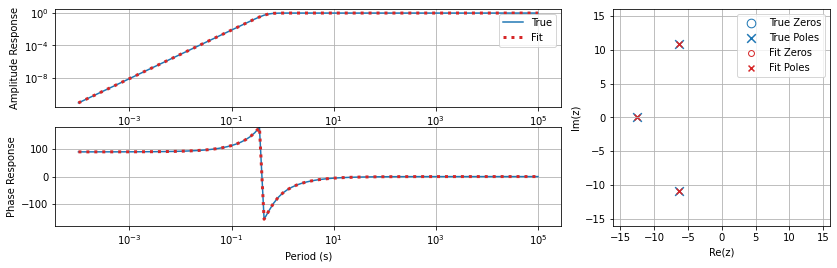

In [16]:
print("PARAMETERIZATION: 0 zeros, 3 poles")
NIMS_Fit_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, NIMS_Bresp, 
                                                0, 3, regularize=True)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_Fit_ZPK, 
              w_values=test_w)

PARAMETERIZATION: 7 zeros, 7 poles
Regularization Parameter:  2718.5882427329457
Max/Min Filter Factors:  1.0  /  2.6393105503631132e-30


/home/kkappler/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1628: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


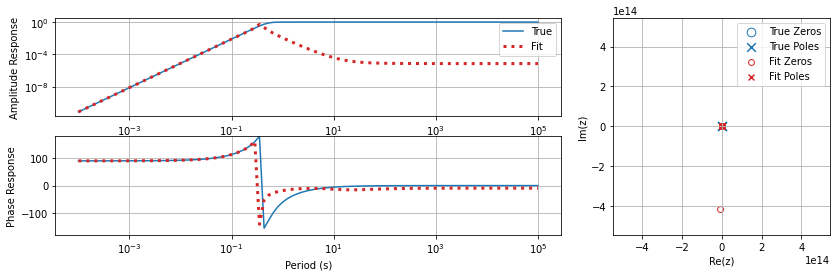

In [17]:
print("PARAMETERIZATION: 7 zeros, 7 poles")
NIMS_Fit_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, NIMS_Bresp, 
                                                7, 7, regularize=True)
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_Fit_ZPK, 
              w_values=test_w)

<br>  
**Fitting NIMS E response (total) with linear approach, using S-K iteration**

PARAMETERIZATION: 1 zero, 6 poles
Number of S-K iterations:  1


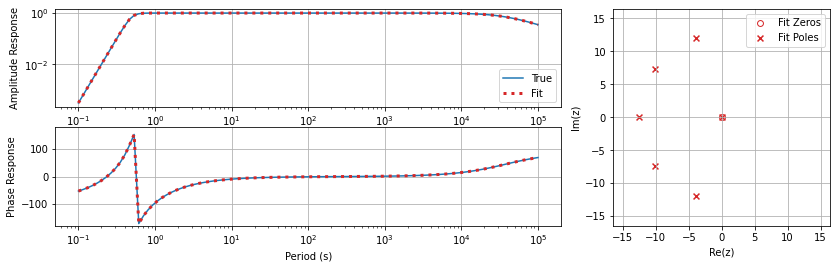

True Zeros:  [0.]
Fit Zeros:  [-4.63714494e-08+5.7406444e-08j]
True Poles:  [-0.00016667] [ -3.88301+11.9519j   -3.88301-11.9519j  -10.1662  +7.38651j
 -10.1662  -7.38651j -12.5664  +0.j     ]
Fit Poles:  [-3.88301000e+00-1.19519000e+01j -1.01662000e+01-7.38651000e+00j
 -3.88301000e+00+1.19519000e+01j -1.25664000e+01+1.95847113e-10j
 -1.01662000e+01+7.38651000e+00j -1.66713332e-04+5.74402212e-08j]


In [18]:
print("PARAMETERIZATION: 1 zero, 6 poles")
test_period = np.logspace(-1, 5, num=100)
test_w = 2. * np.pi / test_period
NIMS_w_highpass, NIMS_Ehigh = signal.freqresp(NIMS_Electric_Highpass, 
                                              w=test_w)
NIMS_w_lowpass, NIMS_Elow = signal.freqresp(NIMS_Electric_5PoleLowpass, 
                                            w=test_w)
NIMS_w = NIMS_w_lowpass
NIMS_Eresp = NIMS_Ehigh * NIMS_Elow
NIMS_EFit_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(NIMS_w, NIMS_Eresp, 
                                                1, 6, 
                                                useSKiter=True)
plot_response(w_obs=NIMS_w, resp_obs=NIMS_Eresp, zpk_pred=NIMS_EFit_ZPK, 
              w_values=test_w)
print("True Zeros: ", NIMS_Electric_Highpass.zeros)
print("Fit Zeros: ", NIMS_EFit_ZPK.zeros)
print("True Poles: ", NIMS_Electric_Highpass.poles, 
      NIMS_Electric_5PoleLowpass.poles)
print("Fit Poles: ", NIMS_EFit_ZPK.poles)

<br><br>  
**Now trying fitting the Zen coil response with the linear approach, no S-K iteration**

PARAMETERIZATION: 8 zero, 8 poles


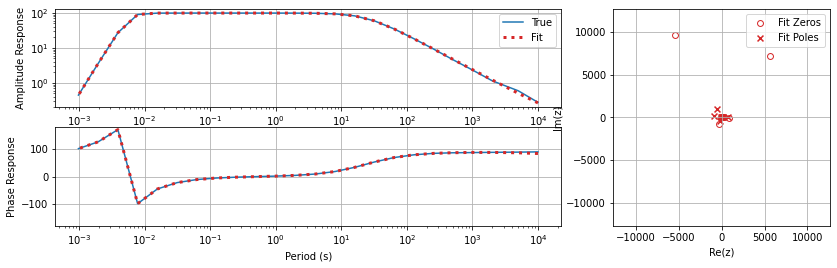

In [36]:
n_zeros=8;
n_poles=8;
print("PARAMETERIZATION: {} zero, {} poles".format(n_zeros, n_poles))
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies, 
                                                zen_complex_response,
                                                n_zeros, n_poles, useSKiter=False)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_ZPK, w_values=zen_response[:, 0])

PARAMETERIZATION: 7 zeros, 7 poles


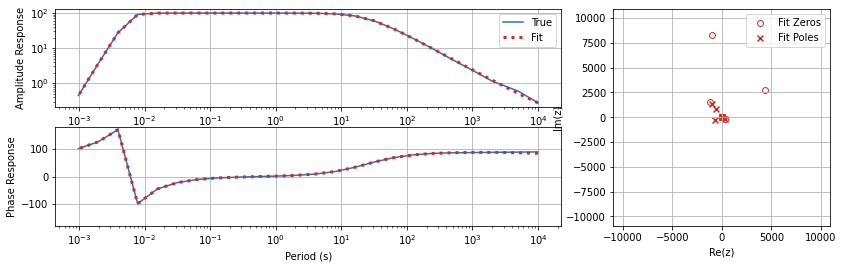

In [20]:
print("PARAMETERIZATION: 7 zeros, 7 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                7, 7, useSKiter=False,
                                                regularize=False)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_ZPK, w_values=zen_response[:, 0])

PARAMETERIZATION: 10 zeros, 10 poles


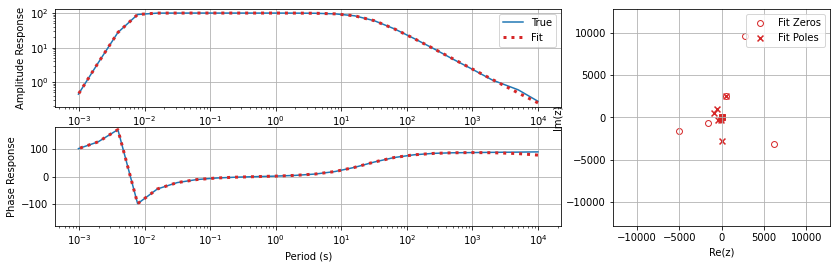

In [16]:
print("PARAMETERIZATION: 10 zeros, 10 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                10, 10, useSKiter=False,
                                                regularize=False)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_ZPK, w_values=zen_response[:, 0])

**Now trying fitting the Zen coil response with the linear approach with S-K iteration**

PARAMETERIZATION: 1 zero, 7 poles
Number of S-K iterations:  100


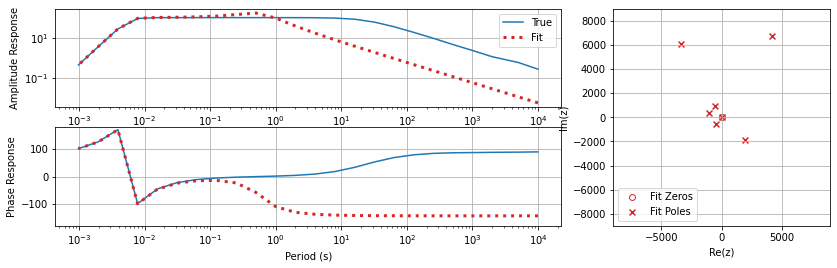

In [17]:
print("PARAMETERIZATION: 1 zero, 7 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                1, 7, useSKiter=True)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_ZPK, w_values=zen_response[:, 0])

PARAMETERIZATION: 7 zeros, 7 poles
Number of S-K iterations:  10


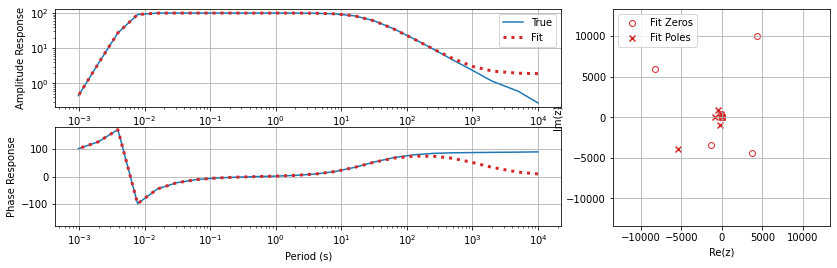

In [18]:
print("PARAMETERIZATION: 7 zeros, 7 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                7, 7, 
                                                useSKiter=True)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_ZPK, 
              w_values=zen_response[:, 0])

PARAMETERIZATION: 10 zeros, 10 poles
Number of S-K iterations:  13


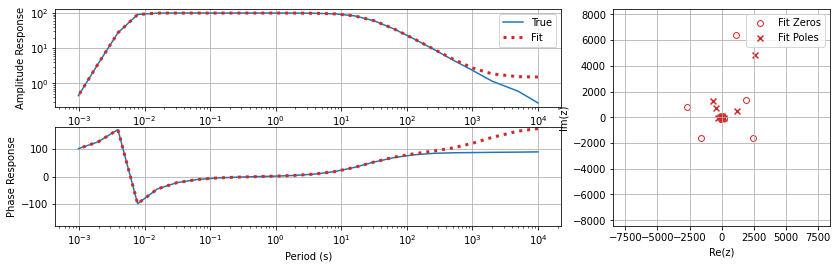

In [19]:
print("PARAMETERIZATION: 10 zeros, 10 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                10, 10, 
                                                useSKiter=True)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_ZPK, 
              w_values=zen_response[:, 0])

<br>  
**Trying to fit Zen coil response with regularized linear least squares, no S-K iteration**

PARAMETERIZATION: 1 zero, 7 poles
Regularization Parameter:  0.0001
Max/Min Filter Factors:  1.0  /  0.999999944819405


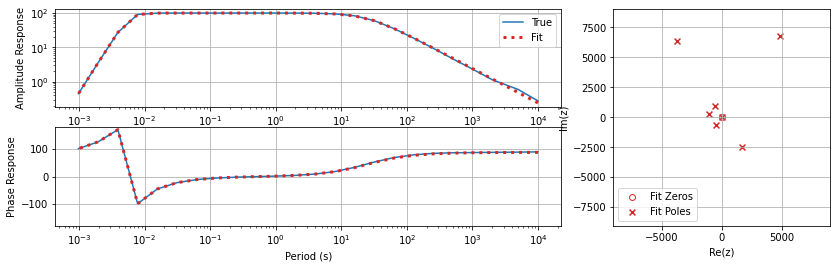

In [20]:
print("PARAMETERIZATION: 1 zero, 7 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                1, 7, regularize=True)
plot_response(w_obs=zen_angular_frequencies, zpk_pred=Zen_ZPK,
              resp_obs=zen_complex_response, w_values=zen_response[:,0])

PARAMETERIZATION: 7 zeros, 7 poles
Regularization Parameter:  0.007220809018385471
Max/Min Filter Factors:  1.0  /  0.3243396474213219


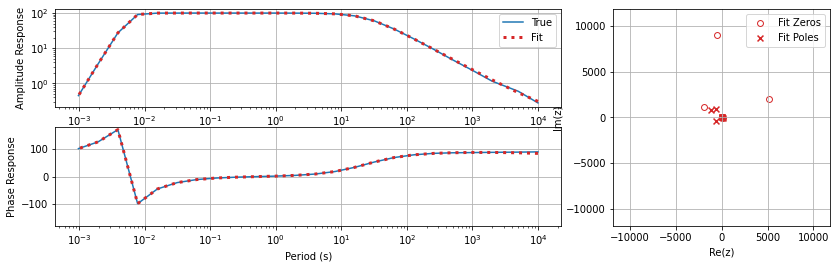

In [21]:
print("PARAMETERIZATION: 7 zeros, 7 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                7, 7, regularize=True)
plot_response(w_obs=zen_angular_frequencies, zpk_pred=Zen_ZPK,
              resp_obs=zen_complex_response, w_values=zen_response[:,0])

PARAMETERIZATION: 10 zeros, 10 poles
Regularization Parameter:  14.849682622544666
Max/Min Filter Factors:  1.0  /  1.3403626783077374e-10


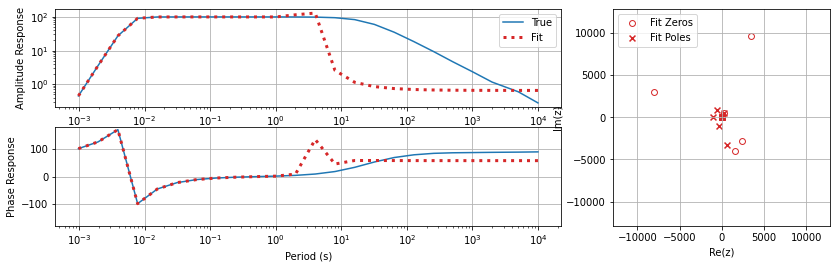

In [22]:
print("PARAMETERIZATION: 10 zeros, 10 poles")
Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(zen_angular_frequencies,
                                                zen_complex_response,
                                                10, 10, useSKiter=False,
                                                regularize=True)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response, zpk_pred=Zen_ZPK, 
              w_values=zen_response[:, 0])

Using S-K iteration with the Zen coil response skrews up the fit. The regularization doesn't really seem to help.

And regardless of the use of S-K iteration or regularization, for the Zen coil response, the poles here aren't coming in conjugate pairs, and some of the poles are plotting on the positive side of the real axis. **This might be a problem...?** My impression is that, for stable real systems (no runaway gains, real time series comes in, real time series comes out), the poles/zeros should come in complex conjugate pairs (or fall along the real axis) and should be restricted to the left half plane (-Re). But maybe I'm wrong about that...
<br> 
  


<h2>Vector Fitting</h2>

Vector fitting is another method in the signal processing world to fit a function to complex response data. Instead of using the transfer function (or factored poles/zeros) representation of the system response, vector fitting uses the partial fractions expansion of the rational function:

$\displaystyle h(s) = \sum_{n=1}^{N} \frac{c_{n}}{s - p_{n}} + d + s \cdot h$

where $ c_{n} $ are the system residues, $ p_{n} $ are the system poles, $d$ and $h$ are constants, and $s$ is complex frequency.

I'm using someone else's implementation of the algorithm here, so it's sort of a black box, and it also is perhaps overkill for our relatively simple systems. (VF seems to be used on complicated functions, not the simple functions that we deal with: flat in some pass band and then falling off with frequency on either side.)  

**Vector Fitting with NIMS B Response**

poles: -12.5666 + 0j, -11.5852 + 0j, -6.34538 + -10.8346j, -6.34538 + 10.8346j, -6.28322 + -10.8827j, -6.28322 + 10.8827j
residues: 12.5644 + 0j, 0.00181701 + 0j, 0.00128419 + 0.0151252j, 0.00128419 + -0.0151252j, -6.28442 + 3.61257j, -6.28442 + -3.61257j
offset: -1.31964e-08
slope: 1.03931e-10


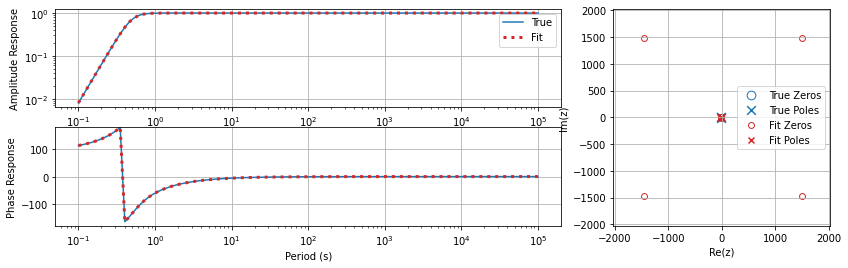

# poles:  6 ;   # zeros:  7


In [23]:
test_period = np.logspace(-1, 5, num=100)
test_w = 2. * np.pi / test_period
NIMS_w, NIMS_Bresp = signal.freqresp(NIMS_Magnetic_3PoleLowpass, 
                                     w=test_w)
poles, residues, d, h = vectfit.vectfit_auto(NIMS_Bresp, 1.j*NIMS_w, n_poles=3)
num_, den_ = signal.invres(residues, poles, [h, d])
NIMS_VF_ZPK = signal.TransferFunction(num_, den_).to_zpk()
plot_response(zpk_obs=NIMS_Magnetic_3PoleLowpass, zpk_pred=NIMS_VF_ZPK, 
              w_values=NIMS_w)
print("# poles: ", NIMS_VF_ZPK.poles.size, ";   # zeros: ", 
      NIMS_VF_ZPK.zeros.size)

**Vector Fitting with Zen coil response**

poles: -1072.29 + 0j, -538.767 + -919.537j, -538.767 + 919.537j, -0.261917 + 0j
residues: 111274 + 0j, -55091.6 + 29648.9j, -55091.6 + -29648.9j, -26.0316 + 0j
offset: -0.107995
slope: 3.11315e-05


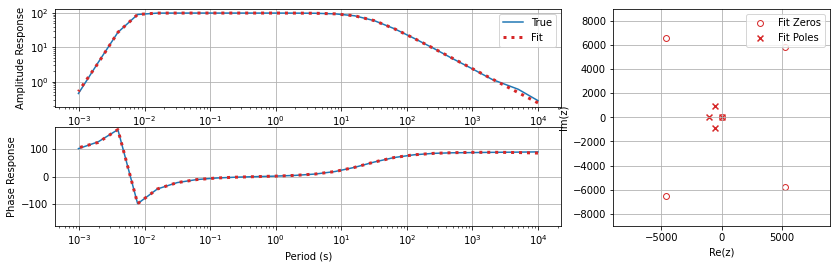

# poles:  4 ;   # zeros:  5


In [24]:
poles, residues, d, h = \
    vectfit.vectfit_auto(zen_complex_response,
                         1.j * zen_angular_frequencies,
                         n_poles=2)
num_, den_ = signal.invres(residues, poles, [h, d])
Zen_VF_ZPK = signal.TransferFunction(num_, den_).to_zpk()
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response,
              zpk_pred=Zen_VF_ZPK, w_values=zen_response[:, 0])
print("# poles: ", Zen_VF_ZPK.poles.size, ";   # zeros: ", 
      Zen_VF_ZPK.zeros.size)

Although I'm telling the VF algorithm to start with just a few poles, it is automatically adding more poles based on some internal criteria. This is resulting in overfitting the NIMS B response curve with too many poles (and zeros). For the fit to the Zen coil response, the poles are at least coming out in conjugate pairs, but the algorithm is also producing zeros in the right half of the complex plane.

However, this is again at least producing a poles-zeros representation of the response function that captures the amplitude and phase behavior correctly...

<h2>Automated Poles/Zeros Fitting</h2>

This is a simple code snippet that could be used to pick out a parameterization for a poles-zeros-gain representation of a complex response lookup table. Basic idea in my implementation here:
<ol>
    <li>Loop over a number of poles and zeros (up to an arbitrary total number).</li>
    <li>Fit the given number of poles/zeros to the lookup table complex values.</li>
    <li>Evalute misfit of the fit via some metric.</li>
    <li>Once the misfits from the all poles/zeros combinations have been evaluated, pick the fit that has the least number of zeros while also reaching some target misfit level.
</ol>
Picking the parameterization with the least number of zeros makes the most sense to me. With the types of system responses we generally deal with (flat in some pass band, then steeply rolling of on the sides), we're most likely going to have more poles than zeros (e.g., Buttersworth 3 pole, 5 pole, etc.). Here, I'm just using the simplest implementation of the linear least squares problem (no iterative reweighting, no regularization).

In [25]:
misfit_grid = np.zeros((11, 11))
for m in range(11):
    for n in range(11):
        Zen_ZPK = \
    Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(
        zen_angular_frequencies, zen_complex_response, m, n)
        w_pred, resp_pred = signal.freqresp(Zen_ZPK, 
                                            w=zen_angular_frequencies)
        misfit_grid[m, n] = np.mean(np.absolute(
                                zen_complex_response - resp_pred))

/home/kkappler/.local/lib/python3.6/site-packages/scipy/signal/filter_design.py:1628: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [26]:
def find_optimal_parameterization(misfit, target_misfit_value=1.):
    for m in range(11):
        for n in range(11):
            if misfit[m, n] <= target_misfit_value:
                return m, n

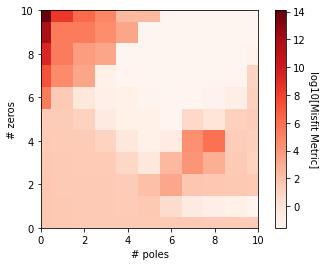

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
cax = ax.pcolormesh(np.arange(12)-0.5, np.arange(12)-0.5, 
                    np.log10(misfit_grid), cmap='Reds')
ax.set_xlabel('# poles')
ax.set_ylabel('# zeros')
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
cbar = fig.colorbar(cax)
cbar.set_label('log10[Misfit Metric]', rotation=270, labelpad=12)
plt.show()

CHOSEN PARAMETERIZATION TO REACH DESIRED MISFIT: 1 zeros, 7 poles


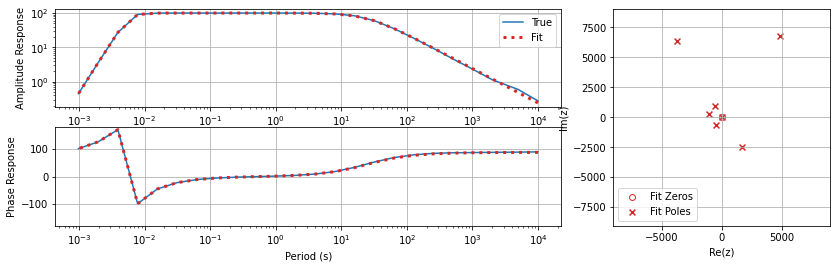

In [28]:
m, n = \
    find_optimal_parameterization(misfit_grid, target_misfit_value=1.)
print("CHOSEN PARAMETERIZATION TO REACH DESIRED MISFIT: {:d} zeros, "
      "{:d} poles".format(m, n))
Zen_ZPK = Fit_ZerosPolesGain_toFrequencyResponse_LLSQ(
    zen_angular_frequencies, zen_complex_response, m, n, 
    useSKiter=False, regularize=False)
plot_response(w_obs=zen_angular_frequencies, 
              resp_obs=zen_complex_response, zpk_pred=Zen_ZPK, 
              w_values=zen_angular_frequencies)

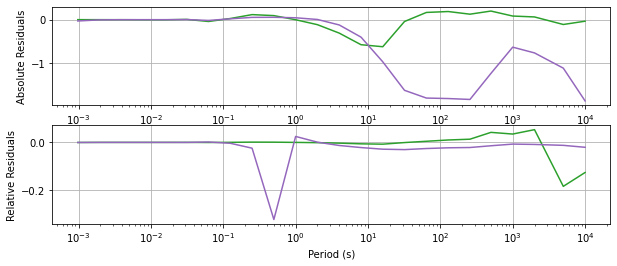

In [29]:
w_pred, resp_pred = signal.freqresp(Zen_ZPK, w=zen_angular_frequencies)
amplitude_residuals = \
    np.absolute(resp_pred) - np.absolute(zen_complex_response)
phase_residuals = \
    np.angle(resp_pred, deg=True) - np.angle(zen_complex_response, 
                                             deg=True)
fig = plt.figure(figsize=(10, 4))
ax_abs = fig.add_subplot(211)
ax_abs.plot(zen_period, amplitude_residuals, c='tab:green')
ax_abs.plot(zen_period, phase_residuals, c='tab:purple')
ax_abs.set_xscale('log')
ax_abs.set_ylabel('Absolute Residuals')
ax_abs.grid()
ax_rel = fig.add_subplot(212)
ax_rel.plot(zen_period, 
            amplitude_residuals/np.absolute(zen_complex_response), 
            c='tab:green')
ax_rel.plot(zen_period,
            phase_residuals/np.angle(zen_complex_response, deg=True), 
            c='tab:purple')
ax_rel.set_xscale('log')
ax_rel.set_xlabel('Period (s)')
ax_rel.set_ylabel('Relative Residuals')
ax_rel.grid()
plt.show()

<h2>Concluding Thoughts/Questions</h2>

So, using either linear least squares or vector fitting, we can derive a poles-zeros-gain representation of the Zen coil response lookup table. The question is, does it matter if the poles/zeros aren't coming out in conjugate pairs and if any poles/zeros appear in the right half (+Re) of the complex plane. My (perhaps erroneous) impression is that, for the real systems we deal with (real-valued time series comes in, real-valued time series comes out, no instabilities or runaway gains in the system), poles/zeros should come in complex conjugate pairs (or fall along the real axis) and should be restricted to the left half plane (-Re). But maybe I'm wrong about that. 

One way or another, we have a poles/zeros/gain representation at some level of misfit to the lookup table response, and maybe (hopefully) that's good enough for archiving with IRIS (even if the fit is overparameterized with too many poles/zeros, or even if the fit isn't 100% perfect).

<h3>References</h3>

https://cdn.intechopen.com/pdfs/57667.pdf

**Linear LS Approach**

https://www.dsprelated.com/freebooks/filters/Filter_Design_Minimizing_L2.html

https://www.dsprelated.com/showcode/20.php

**Vector Fitting**

https://arxiv.org/pdf/1908.08977.pdf

https://github.com/PhilReinhold/vectfit_python
